### <span style="font-family: Century Gothic">Modelling and Testing (fMRI ADHD/Sex Classification)</span>

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import joblib

<span style="font-family: Century Gothic; font-size:15px">Load Dataset</span>

In [2]:
df = pd.read_csv('Cleaned_fMRI.csv')
df.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,0.047912,0.147614,0.035215,0.041143,0.070673,0.080293,0.063638,-0.016682,0.043650,...,-0.031380,0.032986,0.081980,0.093708,0.021903,0.029458,-0.016072,0.169368,1,0
1,00fV0OyyoLfw,-0.003560,0.131635,0.067454,0.073367,0.013845,0.198074,0.038971,-0.109366,-0.034447,...,0.038632,-0.042040,0.125651,0.127045,0.142448,0.051943,0.138729,0.168951,1,0
2,04X1eiS79T4B,-0.076074,0.162668,0.050365,0.035320,0.055263,0.047298,0.155932,0.012768,0.084281,...,0.013774,-0.057094,0.084471,0.075582,0.093687,0.091592,0.114817,0.157812,0,1
3,05ocQutkURd6,0.054913,0.160764,0.150480,0.113151,0.135581,0.118498,0.032319,-0.078683,-0.013995,...,-0.075685,-0.029209,0.087122,0.009254,0.114800,0.218728,0.090305,0.159943,0,1
4,06YUNBA9ZRLq,0.100683,0.103170,0.046506,0.127893,0.075231,0.019648,0.116546,0.035825,0.044905,...,-0.005693,-0.001515,0.166933,0.005170,0.005126,0.126259,-0.038223,0.181322,1,0


In [3]:
df.shape

(1213, 19903)

<span style="font-family: Century Gothic; font-size:15px">Checking the null values</span>

In [4]:
assert np.mean(df.isnull().sum()) == 0, "Dataset contains null values!"

<span style="font-family: Century Gothic; font-size:25px">Dataset Summary:</span>

<span style="font-family: Century Gothic; font-size:15px">`1213` samples with `19903` features. </span>

<span style="font-family: Century Gothic; font-size:15px"> No missing values, meaning the dataset is fully preprocessed. </span>

<span style="font-family: Century Gothic; font-size:25px"> Target Variables: </span>

<span style="font-family: Century Gothic; font-size:15px"> ADHD_Outcome `0 = No ADHD`, `1 = ADHD`</span>

<span style="font-family: Century Gothic; font-size:15px"> Sex_F `0 = Male`, `1 = Female`</span>

In [5]:
df_model = df.copy()

# <span style="font-family: Century Gothic"> fMRI Modelling </span>

In [6]:
# Drop participant ID, extract labels
X = df_model.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F']).values
y_adhd = df_model['ADHD_Outcome'].values
y_sex = df_model['Sex_F'].values

In [7]:
# Split into Train/Validation/Test (60/20/20)

def stratified_split(X, y):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        stratify=y, 
        random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.25, 
        stratify=y_temp, 
        random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
# Train/Test Split
X_train_adhd, X_val_adhd, X_test_adhd, y_train_adhd, y_val_adhd, y_test_adhd = stratified_split(
    X, 
    y_adhd
)

X_train_sex, X_val_sex, X_test_sex, y_train_sex, y_val_sex, y_test_sex = stratified_split(
    X, 
    y_sex
)

In [16]:
def calculate_class_weight(y_train: pd.Series):
    return dict(
        enumerate(
            compute_class_weight(
                'balanced',
                classes=np.unique(y_train),
                y = y_train
            )
        )
    )

In [18]:
adhd_class_weight = calculate_class_weight(y_train_adhd)
sex_class_weight = calculate_class_weight(y_train_sex)

In [19]:
adhd_class_weight, sex_class_weight

({0: np.float64(1.5873362445414847), 1: np.float64(0.7299196787148594)},
 {0: np.float64(0.7620545073375262), 1: np.float64(1.454)})

# <span style="font-family: Century Gothic; font-size:15px"> Normalize Data </span>

In [9]:
scaler = StandardScaler()
X_train_adhd_scaled = scaler.fit_transform(X_train_adhd)
X_val_adhd_scaled = scaler.transform(X_val_adhd)
X_test_adhd_scaled = scaler.transform(X_test_adhd)

X_train_sex_scaled = scaler.fit_transform(X_train_sex)
X_val_sex_scaled = scaler.fit_transform(X_val_sex)
X_test_sex_scaled = scaler.transform(X_test_sex)

# <span style="font-family: Century Gothic; font-size:15px"> Model Architecture </span>

In [14]:
# Define Dense Model Architecture
def create_model(input_dim, lr=0.001, dropout_rate=0.3, metrics='accuracy'):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[metrics]
    )
    
    return model

In [11]:
# Checkpoint
adhd_ckpt = 'adhd_best_model.keras'
sex_ckpt = 'sex_best_model.keras'

# <span style="font-family: Century Gothic;"> ADHD Modelling </span>

In [12]:
# Early Stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        restore_best_weights=True
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath=adhd_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

<span style="font-family: Century Gothic; font-size:15px"> Train ADHD Model </span>

In [28]:
# Train CNN for ADHD Classification
adhd_model = create_model(X_train_adhd_scaled.shape[1], metrics=tf.keras.metrics.AUC(name='roc_auc'))

adhd_model.build()
adhd_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │    10,189,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,320,897 (39.37 MB)

 Trainable params: 10,320,897 (39.37 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_adhd = adhd_model.fit(
    X_train_adhd_scaled, 
    y_train_adhd, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_adhd_scaled, y_val_adhd),
    callbacks=callbacks,
    verbose=1,
    class_weight=adhd_class_weight
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 1.0144 - roc_auc: 0.5406 - val_loss: 0.8236 - val_roc_auc: 0.5230
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0820 - roc_auc: 0.9967 - val_loss: 0.9765 - val_roc_auc: 0.5336


<span style="font-family: Century Gothic; font-size:15px"> Plot Accuracy Curve </span>

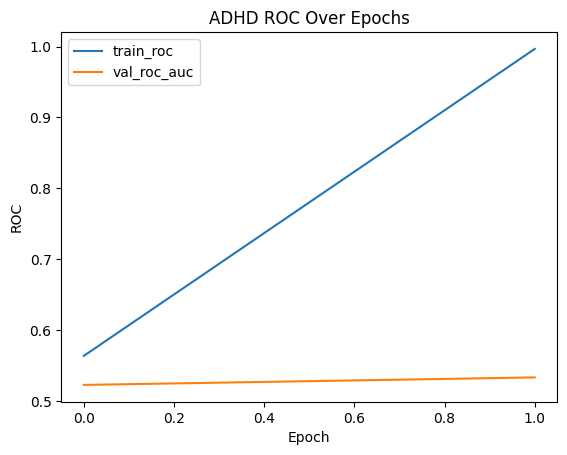

In [30]:
plt.plot(history_adhd.history['roc_auc'], label='train_roc')
plt.plot(history_adhd.history['val_roc_auc'], label = 'val_roc_auc')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('ADHD ROC Over Epochs')
plt.legend()
plt.show()

In [31]:
print("🔹 ADHD ROC AUC Score:", 
    roc_auc_score(
        y_test_adhd, 
        adhd_model.predict(X_test_adhd_scaled)
    )
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
🔹 ADHD ROC AUC Score: 0.5540603974338913


# <span style="font-family: Century Gothic;"> Sex Modelling </span>

In [18]:
callbacks[1] = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=sex_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

In [35]:
# Train CNN for Sex Classification
sex_model = create_model(X_train_sex_scaled.shape[1])

sex_model.build()
sex_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │    10,189,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,320,897 (39.37 MB)

 Trainable params: 10,320,897 (39.37 MB)

 Non-trainable params: 0 (0.00 B)

<span style="font-family: Century Gothic; font-size:15px"> Train Sex Model </span>

In [39]:
history_sex = sex_model.fit(
    X_train_sex_scaled, 
    y_train_sex, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_adhd_scaled, y_val_sex),
    callbacks=callbacks,
    verbose=1,
    class_weight=sex_class_weight
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9914 - loss: 0.0374 - val_accuracy: 0.5514 - val_loss: 3.6199
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.5514 - val_loss: 3.9679


<span style="font-family: Century Gothic; font-size:15px"> Plot Accuracy Curve </span>

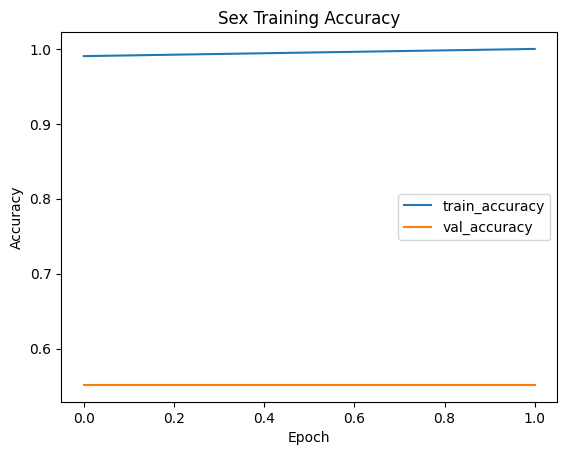

In [40]:
plt.plot(history_sex.history['accuracy'], label='train_accuracy')
plt.plot(history_sex.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Sex Training Accuracy')
plt.show()

In [41]:
print("🔹 Sex ROC AUC Score:", 
    roc_auc_score(
        y_test_sex, 
        sex_model.predict(X_test_sex_scaled)
    )
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
🔹 Sex ROC AUC Score: 0.7295180722891565


# <span style="font-family: Century Gothic"> Hyperparameter Tuning for RandomForest

In [43]:
print("\n🔍 Hyperparameter Tuning - Random Forest (ADHD)...")
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(
    rfc, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    verbose=1
)

rf_grid.fit(X_train_adhd_scaled, y_train_adhd)
rf_best = rf_grid.best_estimator_

y_pred = rf_best.predict(X_val_adhd_scaled)
y_proba = rf_best.predict_proba(X_val_adhd_scaled)[:, 1]

print('-----------------------------------------')
print(f'Best Params: {rf_grid.best_params_}')
print('-----------------------------------------')
print(classification_report(y_val_adhd, y_pred))
print('-----------------------------------------')
print(f'ROC AUC Score: {roc_auc_score(y_val_adhd, y_proba):.4f}')
print('-----------------------------------------')

joblib.dump(rf_best, "adhd_rf_model.pkl")


🔍 Hyperparameter Tuning - Random Forest (ADHD)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
-----------------------------------------
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.03      0.05        76
           1       0.69      0.99      0.81       167

    accuracy                           0.69       243
   macro avg       0.60      0.51      0.43       243
weighted avg       0.63      0.69      0.57       243

-----------------------------------------
ROC AUC Score: 0.5840
-----------------------------------------


['adhd_rf_model.pkl']

# <span style="font-family: Century Gothic"> Hyperparameter Tuning for MLP

In [44]:
print("\n🔍 Hyperparameter Tuning - MLP (Sex)...")

mlp = MLPClassifier(max_iter=300)
mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}

mlp_grid = GridSearchCV(
    mlp, 
    mlp_params, 
    cv=3, 
    scoring='accuracy', 
    verbose=1
)

mlp_grid.fit(X_train_sex_scaled, y_train_sex)
mlp_best = mlp_grid.best_estimator_

y_pred = mlp_best.predict(X_val_sex_scaled)
y_proba = mlp_best.predict_proba(X_val_sex_scaled)[:, 1]

print('-----------------------------------------')
print(f'Best Params: {mlp_grid.best_params_}')
print('-----------------------------------------')
print(classification_report(y_val_sex, y_pred))
print('-----------------------------------------')
print(f'ROC AUC Score: {roc_auc_score(y_val_sex, y_proba):.4f}')
print('-----------------------------------------')

joblib.dump(mlp_best, "sex_mlp_model.pkl")


🔍 Hyperparameter Tuning - MLP (Sex)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
-----------------------------------------
Best Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50)}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       160
           1       0.51      0.41      0.45        83

    accuracy                           0.66       243
   macro avg       0.61      0.60      0.60       243
weighted avg       0.65      0.66      0.65       243

-----------------------------------------
ROC AUC Score: 0.6870
-----------------------------------------


['sex_mlp_model.pkl']

# <span style="font-family: Century Gothic"> Model Comparison

In [45]:
def calc_cross_val_score(model, x_train, y_train, cv, scoring='accuracy'):
    rf_scores = cross_val_score(
        model, 
        x_train, 
        y_train, 
        cv=cv, 
        scoring=scoring
    )
    
    return np.mean(rf_scores)

In [59]:
def evaluate_final_model(name, model, X_test, y_test, is_keras=False):
    print(f"\n📊 Final Evaluation: {name}")
    if is_keras:
        y_pred = (model.predict(X_test) > 0.6).astype(int)
        y_proba = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
    print(
        "\n🔹 Classification Report:\n", 
        classification_report(y_test, y_pred)
    )
    print(
        "🔹 ROC AUC Score:", 
        roc_auc_score(
            y_test, 
            y_proba
        )
    )

In [ ]:
# ADHD Model Selection by Cross-Validation
cv = 5

rf_adhd_val = calc_cross_val_score(
    rf_best,
    X_train_adhd_scaled, 
    y_train_adhd, 
    cv,
    scoring='f1'
)

y_pred_adhd = (adhd_model.predict(X_test_adhd) > 0.6).astype(int)

deep_adhd_score =  f1_score(
    y_test_adhd, 
    y_pred_adhd
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [77]:
adhd_models = [
    ("Random Forest", rf_best, rf_adhd_val),
    ("Deep Adhd Model", adhd_model, deep_adhd_score)
]

In [78]:
best_name, adhd_final_model, best_score = max(adhd_models, key=lambda x: x[2])
print(f"✅ Best ADHD Model: {best_name} with score {best_score:.4f}")

✅ Best ADHD Model: Random Forest with score 0.8156


In [79]:
evaluate_final_model(
    best_name, 
    adhd_final_model, 
    X_test_adhd_scaled,
    y_test_adhd,
    is_keras=("Deep" in best_name)
)


📊 Final Evaluation: Random Forest

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.04      0.07        77
           1       0.69      0.98      0.81       166

    accuracy                           0.68       243
   macro avg       0.59      0.51      0.44       243
weighted avg       0.63      0.68      0.58       243

🔹 ROC AUC Score: 0.5790956031919887


In [51]:
# Sex Model Selection by Cross-Validation

mlp_sex_val = calc_cross_val_score(
    mlp_best,
    X_train_sex_scaled, 
    y_train_sex, 
    cv,
    scoring='accuracy'
)

y_sex_adhd = (sex_model.predict(X_test_sex) > 0.6).astype(int)

deep_sex_score =  accuracy_score(
    y_test_adhd, 
    y_pred_adhd
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [80]:
sex_models = [
    ("MLP Model", mlp_best, mlp_sex_val),
    ("Deep Sex Model", sex_model, deep_sex_score)
]

In [81]:
best_name_, sex_final_model, best_score_ = max(sex_models, key=lambda x: x[2])
print(f"✅ Best Sex Model: {best_name_} with score {best_score_:.4f}")

✅ Best Sex Model: MLP Model with score 0.6919


In [82]:
evaluate_final_model(
    best_name_, 
    sex_final_model, 
    X_test_sex_scaled,
    y_test_sex,
    is_keras=("Deep" in best_name)
)


📊 Final Evaluation: MLP Model

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80       160
           1       0.63      0.39      0.48        83

    accuracy                           0.71       243
   macro avg       0.68      0.63      0.64       243
weighted avg       0.70      0.71      0.69       243

🔹 ROC AUC Score: 0.7179969879518072


In [96]:
models = {
    "DEEP_ADHD": (adhd_model, X_test_adhd_scaled, y_test_adhd),
    "RF_ADHD": (rf_best, X_test_adhd_scaled, y_test_adhd),
    "DEEP_SEX": (sex_model, X_test_sex_scaled, y_test_sex),
    "MLP_SEX": (mlp_best, X_test_sex_scaled, y_test_sex)
}

In [100]:
results = []
for name, (model, X_test, y_true) in models.items():
    if 'DEEP' in name:
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred)
    })

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [101]:
comparison_df = pd.DataFrame(results)

comparison_df.to_csv("model_comparison_table.csv", index=False)
comparison_df

,Model,Accuracy,F1 Score,ROC AUC
0,DEEP_ADHD,0.625514,0.734694,0.548349
1,RF_ADHD,0.683128,0.808933,0.510444
2,DEEP_SEX,0.670782,0.555556,0.654330
3,MLP_SEX,0.711934,0.477612,0.633396


<span style="font-family: Century Gothic"> 🧠 ADHD Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> The Random Forest model demonstrates poor overall balance and significant class bias when predicting ADHD outcomes from `fMRI` data.</span>

<span style="font-family: Century Gothic; font-size: 15px">It achieves an `accuracy` of `68%`, but this is largely driven by high performance on `class 1` (likely ADHD), with a `recall` of `98%` and `F1-score` of `0.81`.</span>

<span style="font-family: Century Gothic; font-size: 15px">However, the model performs very poorly on class 0 (likely non-ADHD), with a `recall` of just `4%` and an `F1-score` of `0.07`, indicating that almost all non-ADHD cases are misclassified.</span>

<span style="font-family: Century Gothic; font-size: 15px">The `ROC AUC` score of `0.58` reflects the model's limited ability to distinguish between classes, only marginally above random guessing.</span>

<span style="font-family: Century Gothic; font-size: 15px">The macro averages are low across precision, recall, and F1-score, underscoring the imbalance in prediction quality across classes.</span>

<span style="font-family: Century Gothic; font-size: 15px">Conclusion: In summary, while the model is highly sensitive to ADHD cases, its inability to correctly identify non-ADHD subjects raises concerns. This imbalance suggests a need for data balancing, feature refinement, or a different model choice better suited to the complexity of fMRI data. </span>

<span style="font-family: Century Gothic"> 🧬 Sex Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> The `MLP model` shows moderate performance in classifying sex from `fMRI` data, with a balanced overall `accuracy` of `71%`.</span>

<span style="font-family: Century Gothic; font-size: 15px">The model performs significantly better on `class 0` (likely Male) with an `F1-score` of `0.80` and `recall` of `88%`, indicating strong ability to detect this class.</span>

<span style="font-family: Century Gothic; font-size: 15px">For `class 1` (likely Female), the model struggles, achieving only `39% recall` and an `F1-score` of `0.48`, which points to a noticeable performance gap between classes.</span>

<span style="font-family: Century Gothic; font-size: 15px">The macro-averaged `F1-score 0.64` and `ROC AUC score 0.72` reflect a moderate level of discriminatory power, but still with room for improvement.</span>

<span style="font-family: Century Gothic; font-size: 15px">Conclusion: Overall, while the MLP model demonstrates reasonable effectiveness, its reduced sensitivity to class 1 suggests class imbalance or feature bias. Additional tuning or strategies like oversampling, ensemble methods, or feature selection may help improve generalizability across both sexes.</span>

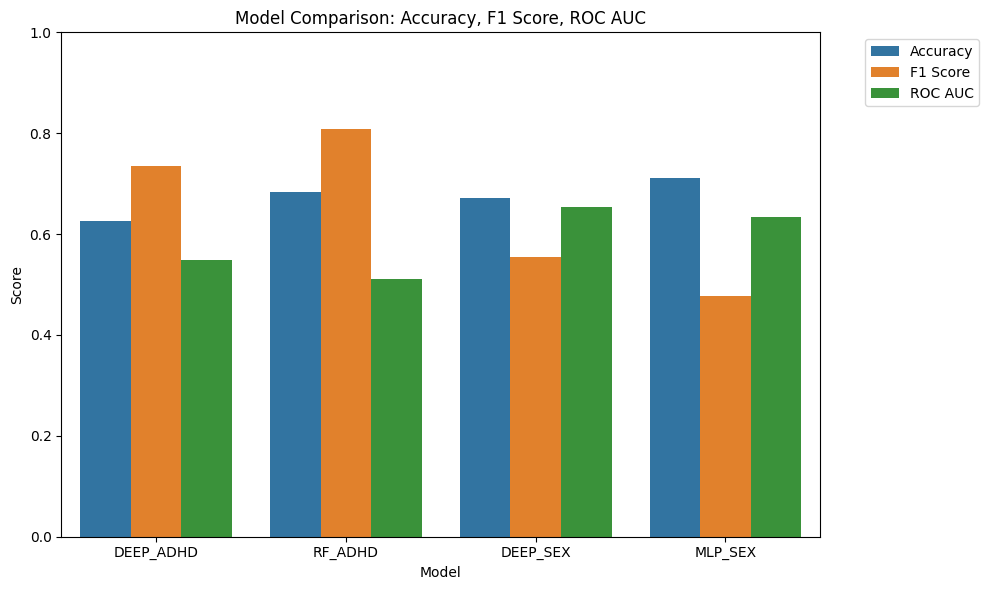

In [102]:
# Melt for easier seaborn plotting
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison: Accuracy, F1 Score, ROC AUC")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()